Based on the demos from the visualDet3D project

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch

from visualDet3D.utils.utils import cfg_from_file
from visualDet3D.networks.utils.registry import DETECTOR_DICT, DATASET_DICT
from visualDet3D.networks.utils import BBox3dProjector, BackProjection
from visualDet3D.utils.utils import draw_3D_box
from visualDet3D.data.pipeline import build_augmentator
import matplotlib.pyplot as plt
print('CUDA available: {}'.format(torch.cuda.is_available()))

cfg = cfg_from_file("./config/config.py")

checkpoint_name = cfg.path.pretrained_checkpoint
write_log = False

CUDA available: True


In [8]:
cfg.data.augmentation.mirrorProb = 0
cfg.data.augmentation.distortProb = 0
cfg.batch_size=1
cfg.trainer.gpu=0
cfg.detector.head.test_cfg.score_thr=0.3
split_to_test='validation'

if split_to_test == 'training':
    dataset_name = cfg.data.train_dataset
elif split_to_test == 'test':
    dataset_name = cfg.data.test_dataset
else:
    dataset_name = cfg.data.val_dataset

dataset = DATASET_DICT[dataset_name](
        cfg, split_to_test
        )

dataset.transform = build_augmentator(cfg.data.test_augmentation)
detector = DETECTOR_DICT[cfg.detector.name](cfg.detector)
detector = detector.cuda()

weight_path = checkpoint_name
state_dict = torch.load(weight_path, map_location='cuda:{}'.format(cfg.trainer.gpu))
detector.load_state_dict(state_dict, strict=False)
detector.eval()

# testing pipeline
#test_func = PIPELINE_DICT[cfg.trainer.test_func]

projector = BBox3dProjector().cuda()
backprojector = BackProjection().cuda()

In [9]:
def draw_bbox2d_to_image(image, bboxes2d, scores, color=(255, 0, 255)):
    drawed_image = image.copy()
    for idx, box2d in enumerate(bboxes2d):
        if(scores[idx].item() > 0.8):
            if write_log:
                s = "good: {}"
                print(s.format(scores[idx].item()))
            cv2.rectangle(drawed_image, (int(box2d[0]), int(box2d[1])), (int(box2d[2]), int(box2d[3])), color, 3)
        else:
            if write_log:
                s = "wrong: {}"
                print(s.format(scores[idx].item()))
    return drawed_image

def corner_homo2bbox(corner_homo):
    """
        corner_homo: [N, 8, 3]
    """
    min_xy  = torch.min(corner_homo[:, :, 0:2], dim=1)[0]
    max_xy  = torch.max(corner_homo[:, :, 0:2], dim=1)[0]
    min_xy[:, 0]  = torch.clamp(min_xy[:, 0], 0, cfg.rgb_shape[1])
    min_xy[:, 1]  = torch.clamp(min_xy[:, 1], 0, cfg.rgb_shape[0])
    max_xy[:, 0]  = torch.clamp(max_xy[:, 0], 0, cfg.rgb_shape[1])
    max_xy[:, 1]  = torch.clamp(max_xy[:, 1], 0, cfg.rgb_shape[0])
    return torch.cat([min_xy, max_xy], dim=1)

def denorm(image):
    new_image = np.array((image * cfg.data.augmentation.rgb_std +  cfg.data.augmentation.rgb_mean) * 255, dtype=np.uint8)
    return new_image

In [10]:
import time
def compute_once(index, is_draw=True):
    data = dataset[index]
    if isinstance(data['calib'], list):
        P2 = data['calib'][0]
    else:
        P2 = data['calib']
    collated_data = dataset.collate_fn([data])
    image = collated_data[0]

    with torch.no_grad():
        image = collated_data[0]
        P2 = collated_data[1]
        
        torch.cuda.synchronize() # Wait for all kernels in all streams on a CUDA device to complete.
        start_time = time.time()
        scores, bbox, obj_names = detector([image.cuda().contiguous(), P2.cuda().contiguous()])
        torch.cuda.synchronize() # Wait for all kernels in all streams on a CUDA device to complete.
        end_time = time.time()
        print(end_time - start_time)
        

    if is_draw:
        rgb_image = denorm(image.squeeze().permute(1, 2, 0).numpy())
        
        P2 = P2[0]
        bbox_2d = bbox[:, 0:4]
        bbox_3d_state = bbox[:, 4:] #[cx,cy,z,w,h,l,alpha]
        
        
        bbox_3d_state_3d = backprojector(bbox_3d_state, P2.cuda()) #[x, y, z, w, h ,l, alpha]
        #bbox_3d_state_3d = torch.cat([position, dims, alpha], dim=1)
        print(bbox_3d_state_3d[:, 0:3])
        _, bbox_3d_corner_homo, _ = projector(bbox_3d_state_3d, P2.cuda())
        
        if len(scores) > 0:
            rgb_image = draw_bbox2d_to_image(rgb_image, bbox_2d.cpu().numpy(), scores)
        for box in bbox_3d_corner_homo:
            box = box.cpu().numpy().T
            rgb_image = draw_3D_box(rgb_image, box)
          
        
        plt.imshow(rgb_image)
        
    return rgb_image, scores, bbox
    

In [11]:
index = 0

1
0.06803059577941895
tensor([[  3.4138,   0.7793,   6.9036],
        [  3.4706,   0.7600,  12.8456],
        [-11.0590,   0.8414,  18.0165],
        [  3.3968,   0.7271,  18.0131],
        [  3.2220,   0.6056,  28.3863],
        [  3.5755,   0.7088,  24.4617],
        [ -2.5110,   0.3032,  48.5652]], device='cuda:0')
good: 0.999998927116394
good: 0.9999897480010986
good: 0.9991208910942078
good: 0.9978002905845642
good: 0.9883727431297302
good: 0.9703873991966248
wrong: 0.3703451156616211


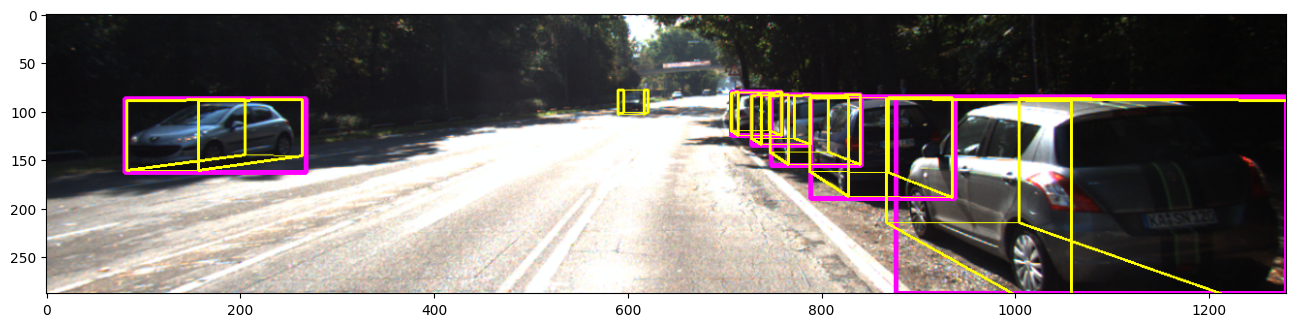

In [13]:
%matplotlib inline
print(index)
fig = plt.figure(figsize=(16,9))
_ = compute_once(index)
plt.show()
index+=1